In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
# output_path = 'output/init-sym-grid'
output_path = 'output/init-clr-grad'
# output_path = 'output/pretrain-sym-grid'
# output_path = 'output/pretrain-clr-grad'

# texture_path = f'output/texture-sym-grid.png'
texture_path = f'output/texture-clr-grad.png'

## Dataset

In [4]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from src.infra.registry import DATASET_REGISTRY
DATASET_REGISTRY

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


{'Dataset': torch.utils.data.dataset.Dataset,
 'SingleFaustDataset': src.dataset.shape_cor.SingleFaustDataset,
 'SingleScapeDataset': src.dataset.shape_cor.SingleScapeDataset,
 'SingleShrec19Dataset': src.dataset.shape_cor.SingleShrec19Dataset,
 'SingleSmalDataset': src.dataset.shape_cor.SingleSmalDataset,
 'SingleDT4DDataset': src.dataset.shape_cor.SingleDT4DDataset,
 'SingleShrec20Dataset': src.dataset.shape_cor.SingleShrec20Dataset,
 'SingleTopKidsDataset': src.dataset.shape_cor.SingleTopKidsDataset,
 'PairDataset': src.dataset.shape_cor.PairDataset,
 'PairFaustDataset': src.dataset.shape_cor.PairFaustDataset,
 'PairScapeDataset': src.dataset.shape_cor.PairScapeDataset,
 'PairShrec19Dataset': src.dataset.shape_cor.PairShrec19Dataset,
 'PairSmalDataset': src.dataset.shape_cor.PairSmalDataset,
 'PairDT4DDataset': src.dataset.shape_cor.PairDT4DDataset,
 'PairShrec20Dataset': src.dataset.shape_cor.PairShrec20Dataset,
 'PairShrec16Dataset': src.dataset.shape_cor.PairShrec16Dataset,
 'Pai

In [6]:
from src.utils.tensor import to_device

dataset = DATASET_REGISTRY['PairFaustDataset'](
    phase='train',
    data_root='../data/FAUST_r/',
    return_evecs='true',
    return_faces='true',
    num_evecs=200,
    return_corr='false',
    return_dist='false',
)

In [7]:
# sample
data = dataset[1]
data_x, data_y = to_device(data['first'], device), to_device(data['second'], device)
data_x['name'], data_y['name']

('tr_reg_000', 'tr_reg_001')

## Model components

### DiffusionNet feature extractor

In [8]:
import src
from src.infra.registry import MODEL_REGISTRY
MODEL_REGISTRY

{'Similarity': src.model.permutation.Similarity,
 'RegularizedFMNet': src.model.fmap.RegularizedFMNet,
 'DiffusionNet': src.model.diffusionnet.DiffusionNet}

In [9]:
feature_extractor = MODEL_REGISTRY['DiffusionNet'](
    in_channels=128,
    out_channels=256,
    cache_dir='../data/FAUST_r/diffusion',
    input_type='wks',
).to(device)
feature_extractor

DiffusionNet(
  (first_linear): Linear(in_features=128, out_features=128, bias=True)
  (last_linear): Linear(in_features=128, out_features=256, bias=True)
  (blocks): ModuleList(
    (0): DiffusionNetBlock(
      (diffusion): LearnedTimeDiffusion()
      (gradient_features): SpatialGradientFeatures(
        (A_re): Linear(in_features=128, out_features=128, bias=False)
        (A_im): Linear(in_features=128, out_features=128, bias=False)
      )
      (mlp): MiniMLP(
        (miniMLP_linear_000): Linear(in_features=384, out_features=128, bias=True)
        (miniMLP_activation_000): ReLU()
        (miniMLP_dropout_001): Dropout(p=0.5, inplace=False)
        (miniMLP_linear_001): Linear(in_features=128, out_features=128, bias=True)
        (miniMLP_activation_001): ReLU()
        (miniMLP_dropout_002): Dropout(p=0.5, inplace=False)
        (miniMLP_linear_002): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (1): DiffusionNetBlock(
      (diffusion): LearnedTimeDiff

In [10]:
# load pretrain weights
if 'pretrain' in output_path:
    network_path = '../checkpoints/faust.pth'
    feature_extractor.load_state_dict(
        torch.load(network_path)['networks']['feature_extractor']
    )
    print(f'Loaded pretrain weights from {network_path}')

In [11]:
feat_x = feature_extractor(
    data_x['verts'].unsqueeze(0),
    data_x['faces'].unsqueeze(0),
)

feat_y = feature_extractor(
    data_y['verts'].unsqueeze(0),
    data_y['faces'].unsqueeze(0),
)

feat_x.shape, feat_y.shape

(torch.Size([1, 4999, 256]), torch.Size([1, 5000, 256]))

In [12]:
# compare features computed from mesh and point cloud
feat_x_pcd = feature_extractor(
    data_x['verts'].unsqueeze(0),
    # data_x['faces'].unsqueeze(0),
)

(feat_x - feat_x_pcd).abs().mean()

tensor(0.1950, device='cuda:0', grad_fn=<MeanBackward0>)

### Funtional maps solver

In [13]:
fm_solver = MODEL_REGISTRY['RegularizedFMNet'](
    bidirectional=True,
).to(device)

fm_solver

RegularizedFMNet()

In [14]:
evals_x = data_x['evals']
evals_y = data_y['evals']
evecs_x = data_x['evecs']
evecs_y = data_y['evecs']
evecs_trans_x = data_x['evecs_trans']
evecs_trans_y = data_y['evecs_trans']

#### Eigen vectors

In [15]:
evecs_x.shape, evecs_trans_x.shape

(torch.Size([4999, 200]), torch.Size([200, 4999]))

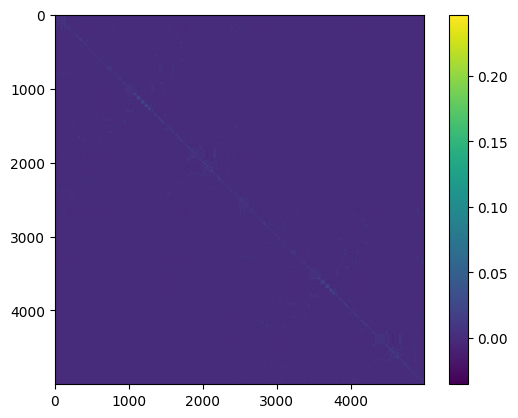

In [16]:
# verify eigen vectors' inverses
import matplotlib.pyplot as plt
from src.utils.tensor import to_numpy

plt.imshow(to_numpy(evecs_x @ evecs_trans_x))
plt.colorbar()
plt.show()

#### Functional maps

In [17]:
Cxy, Cyx = fm_solver(
    feat_x, feat_y,
    evals_x.unsqueeze(0),
    evals_y.unsqueeze(0),
    evecs_trans_x.unsqueeze(0),
    evecs_trans_y.unsqueeze(0),
)

Cxy.shape, Cyx.shape

(torch.Size([1, 200, 200]), torch.Size([1, 200, 200]))

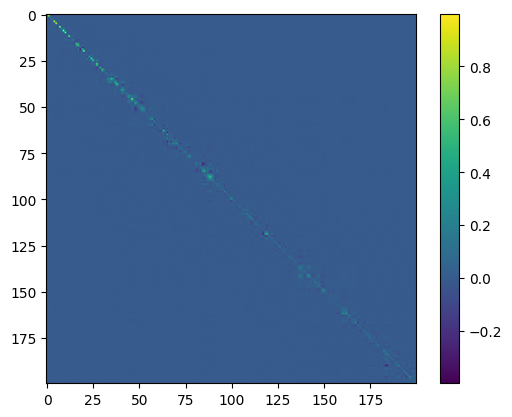

In [18]:
# verify inverse maps

plt.imshow(to_numpy((Cxy @ Cyx)[0]))
plt.colorbar()
plt.show()

### Point-wise correspondence matrix

In [19]:
permutation = MODEL_REGISTRY['Similarity'](
    tau=0.07,
)

In [20]:
import torch.nn.functional as F

feat_x = F.normalize(feat_x, dim=-1, p=2)
feat_y = F.normalize(feat_y, dim=-1, p=2)
similarity = torch.bmm(feat_x, feat_y.transpose(1, 2))

# sinkhorn normalization
Pxy = permutation(similarity)
Pyx = permutation(similarity.transpose(1, 2))

Pxy.shape, Pxy.min(), Pxy.max(), Pxy.mean(), Pxy.std()

(torch.Size([1, 4999, 5000]),
 tensor(6.6581e-08, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.0064, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0003, device='cuda:0', grad_fn=<StdBackward0>))

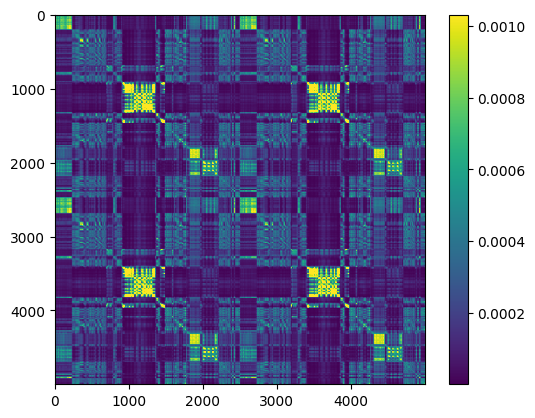

In [21]:
plt.imshow(to_numpy(Pxy), vmin=Pxy.min(), vmax=Pxy.mean() + 3 * Pxy.std())
plt.colorbar()
plt.show()

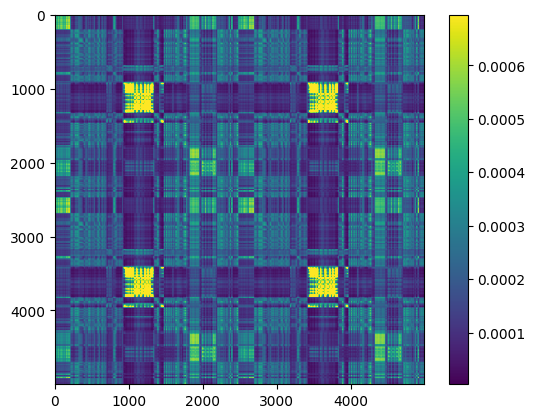

In [22]:
mul = Pxy @ Pyx
plt.imshow(to_numpy(mul), vmin=mul.min(), vmax=mul.mean() + 3 * mul.std())
plt.colorbar()
plt.show()

## Loss

In [23]:
from src.infra.registry import LOSS_REGISTRY
LOSS_REGISTRY

{'MSELoss': torch.nn.modules.loss.MSELoss,
 'SquaredFrobeniusLoss': src.loss.fmap.SquaredFrobeniusLoss,
 'SURFMNetLoss': src.loss.fmap.SURFMNetLoss,
 'PartialFmapsLoss': src.loss.fmap.PartialFmapsLoss,
 'DirichletLoss': src.loss.dirichlet.DirichletLoss}

In [24]:
surfm_loss = LOSS_REGISTRY['SURFMNetLoss'](
    w_bij=1.0,
    w_orth=1.0,
    w_lap=0.0,
)
surfm_loss(Cxy, Cyx, evals_x, evals_y)

{'l_bij': tensor(291.9065, device='cuda:0', grad_fn=<MulBackward0>),
 'l_orth': tensor(286.7654, device='cuda:0', grad_fn=<MulBackward0>)}

In [25]:
align_loss = LOSS_REGISTRY['SquaredFrobeniusLoss'](
    loss_weight=1.0,
)

Cxy_est = torch.bmm(
    evecs_trans_y.unsqueeze(0),
    torch.bmm(Pyx, evecs_x.unsqueeze(0)),
)

Cyx_est = torch.bmm(
    evecs_trans_x.unsqueeze(0),
    torch.bmm(Pxy, evecs_y.unsqueeze(0)),
)

align_loss(Cxy, Cxy_est), align_loss(Cyx, Cyx_est)

(tensor(39.2410, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(40.6079, device='cuda:0', grad_fn=<MulBackward0>))

In [26]:
dirichlet_loss = LOSS_REGISTRY['DirichletLoss'](
    loss_weight=0.5,
)
Lx, Ly = data_x['L'], data_y['L']
dirichlet_loss(torch.bmm(Pxy, data_y['verts'].unsqueeze(0)), Lx.unsqueeze(0))

tensor(1.0090, device='cuda:0', grad_fn=<MulBackward0>)

## Metric

In [27]:
from src.infra.registry import METRIC_REGISTRY
METRIC_REGISTRY

{'L1Loss': torch.nn.modules.loss.L1Loss,
 'MSELoss': torch.nn.modules.loss.MSELoss,
 'MeanDiffRatio': src.metric.stats.MeanDiffRatio,
 'StdDiffRatio': src.metric.stats.StdDiffRatio,
 'calculate_geodesic_error': <function src.metric.geodist.calculate_geodesic_error(dist_x, corr_x, corr_y, p2p, return_mean=True)>,
 'plot_pck': <function src.metric.geodist.plot_pck(geo_err, threshold=0.1, steps=40)>}

In [28]:
from src.utils.fmap import fmap2pointmap

p2p = fmap2pointmap(Cxy.squeeze(), evecs_x, evecs_y)
p2p.shape

torch.Size([5000])

In [29]:
geo_err = METRIC_REGISTRY['calculate_geodesic_error'](
    dist_x=to_numpy(data_x['dist']),
    corr_x=to_numpy(data_x['corr']),
    corr_y=to_numpy(data_y['corr']),
    p2p=to_numpy(p2p),
    return_mean=False,
)
geo_err.shape, geo_err.mean()

((5000,), 0.021396935)

(0.7895333333333334,
 <Figure size 640x480 with 1 Axes>,
 array([0.2106, 0.2108, 0.2202, 0.2488, 0.2852, 0.3472, 0.4086, 0.4898,
        0.5696, 0.6416, 0.696 , 0.7388, 0.7704, 0.7964, 0.821 , 0.8424,
        0.8648, 0.8826, 0.8962, 0.912 , 0.9266, 0.9386, 0.9474, 0.9578,
        0.9646, 0.969 , 0.9736, 0.977 , 0.9812, 0.9844, 0.9858, 0.988 ,
        0.9894, 0.9906, 0.992 , 0.9938, 0.9948, 0.9954, 0.9958, 0.9966]))

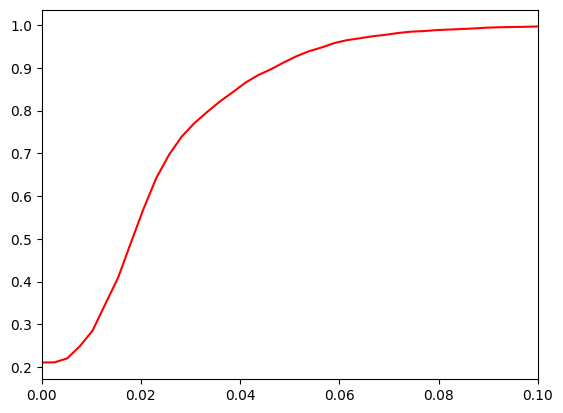

In [30]:
METRIC_REGISTRY['plot_pck'](geo_err)

## Visualization

In [31]:
import os
import shutil

# copy texture file to output directory
os.makedirs(output_path, exist_ok=True)
texture_fname = os.path.basename(texture_path)
cp_texture_path = os.path.join(output_path, texture_fname)

shutil.copy(
    texture_path,
    cp_texture_path,
)

texture_fname, cp_texture_path

('texture-clr-grad.png', 'output/init-clr-grad/texture-clr-grad.png')

In [32]:
from src.utils.texture import write_obj_pair

# write the output obj files
name_x, name_y = data_x['name'], data_y['name']
file_x = os.path.join(output_path, f'{name_x}.obj')
file_y = os.path.join(output_path, f'{name_x}-{name_y}.obj')
faces_x, faces_y = to_numpy(data_x['faces']), to_numpy(data_y['faces'])
verts_x, verts_y = to_numpy(data_x['verts']), to_numpy(data_y['verts'])

write_obj_pair(file_x, file_y, verts_x, faces_x, verts_y, faces_y, to_numpy(Pyx), texture_fname)